### Correlation Coefficients for veg_00108 and veg_00109

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
fname108 = "../image_files/veg_00108.raw"
cube108 = read_hyper(fname108)

fname109 = "../image_files/veg_00109.raw"
cube109 = read_hyper(fname109)

reading and parsing ../image_files/veg_00108.hdr...
reading ../image_files/veg_00108.raw...
reading and parsing ../image_files/veg_00109.hdr...
reading ../image_files/veg_00109.raw...


In [3]:
cube108_sub = cube108.data[:, :, :].astype(float)
print(cube108_sub.shape)

cube109_sub = cube109.data[:, :, :].astype(float)
print(cube109_sub.shape)

(848, 1600, 1600)
(848, 1600, 1600)


In [4]:
mean_E108 = cube108_sub.mean((0,1))
std_E108 = cube108_sub.std((0,1))

mean_E109 = cube109_sub.mean((0,1))
std_E109 = cube109_sub.std((0,1))

In [5]:
E108p = (cube108_sub - mean_E108) / std_E108
E109p = (cube109_sub - mean_E109) / std_E109

In [6]:
E108pf = E108p.reshape(E108p.shape[0] * E108p.shape[1], E108p.shape[2])
E109pf = E109p.reshape(E109p.shape[0] * E109p.shape[1], E109p.shape[2])
ncol108 = E108p.shape[2]
ncol109 = E109p.shape[2]
npix = E108pf.shape[0]

print(E108pf.shape)
print(E109pf.shape)

(1356800, 1600)
(1356800, 1600)


In [7]:
ccmat = np.dot(E108pf.T, E109pf) / npix

In [8]:
print(ccmat.min(), ccmat.max())

0.9190321257487796 0.9956685606605925


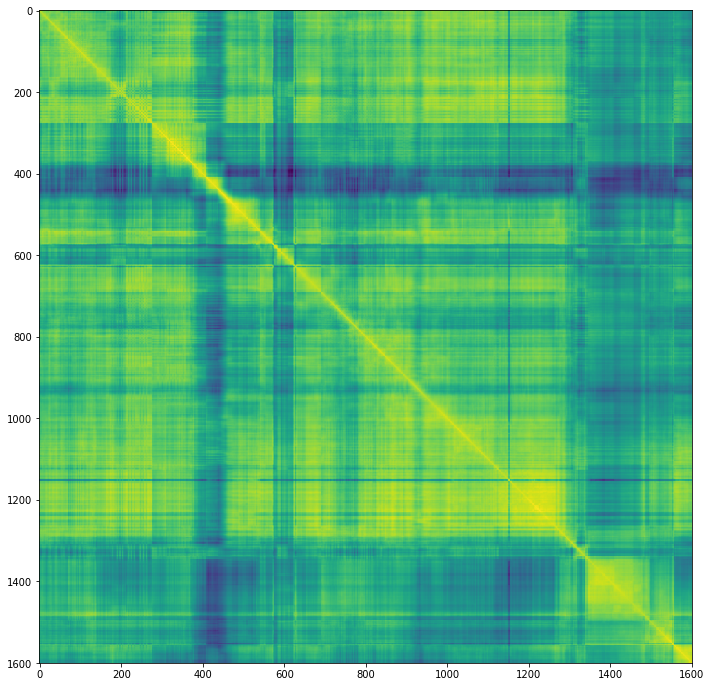

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.imshow(ccmat)

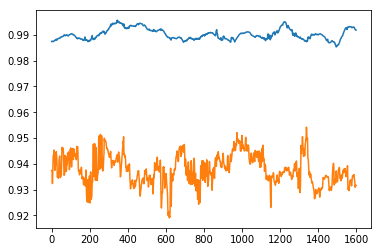

In [10]:
plt.plot(ccmat.max(0))
plt.plot(ccmat.min(0))

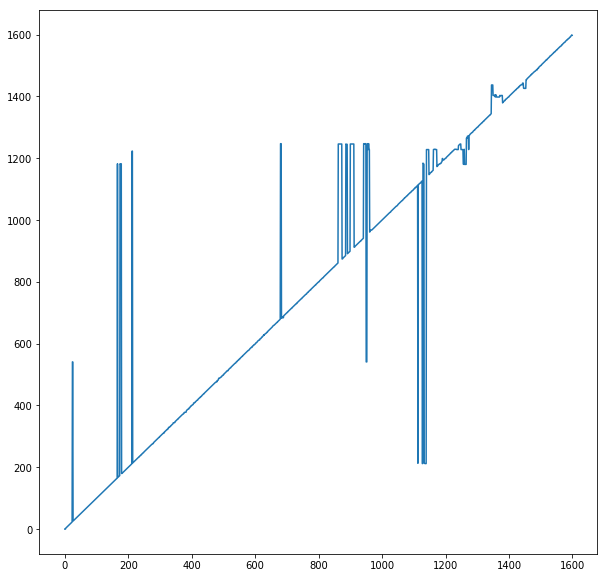

In [11]:
plt.figure(figsize=(10,10))
plt.plot(ccmat.argmax(0))

In [13]:
ind = np.arange(ccmat.shape[0])
ccmat_2 = ccmat.copy()
ccmat_2[ind, ind] = 0.0

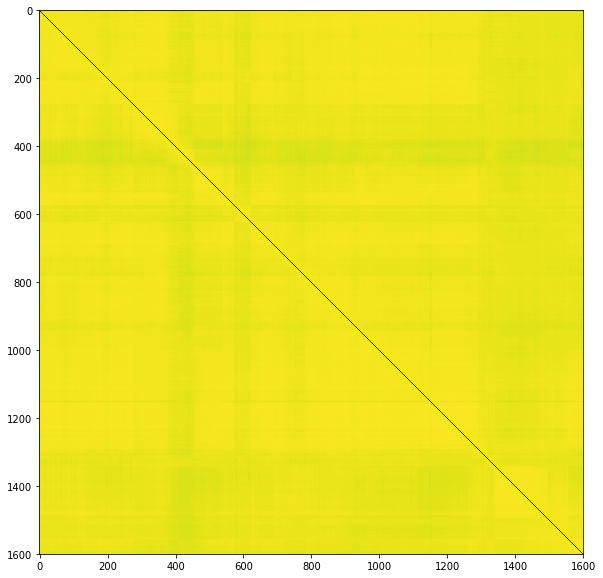

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(ccmat_2)

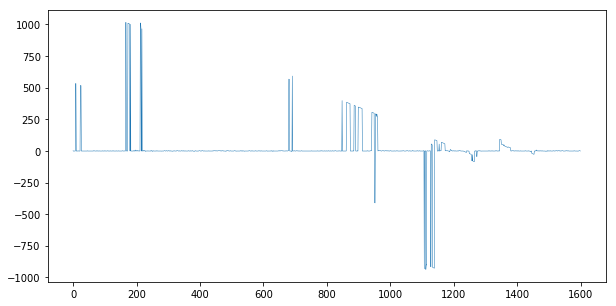

In [17]:
plt.figure(figsize=(10,5))
plt.plot(ccmat_2.argmax(0) - ind, lw=0.5)

## channel 300

In [18]:
cube108_sub300 = cube108.data[300,:,:].astype(float)
cube109_sub300 = cube109.data[300,:,:].astype(float)

In [19]:
mean_300_E108 = cube108_sub300.mean((0))
std_300_E108 = cube108_sub300.std((0))

mean_300_E109 = cube109_sub300.mean((0))
std_300_E109 = cube109_sub300.std((0))

In [20]:
E108p_300 = (cube108_sub300 - mean_300_E108) / std_300_E108
E109p_300 = (cube109_sub300 - mean_300_E109) / std_300_E109

In [21]:
ncol108 = E108p_300.shape[1]
ncol109 = E109p_300.shape[1]
npix = E108p_300.shape[0]

print(E108p_300.shape)
print(E109p_300.shape)

(1600, 1600)
(1600, 1600)


In [22]:
ccmat_300 = np.dot(E109p_300.T, E108p_300) / npix

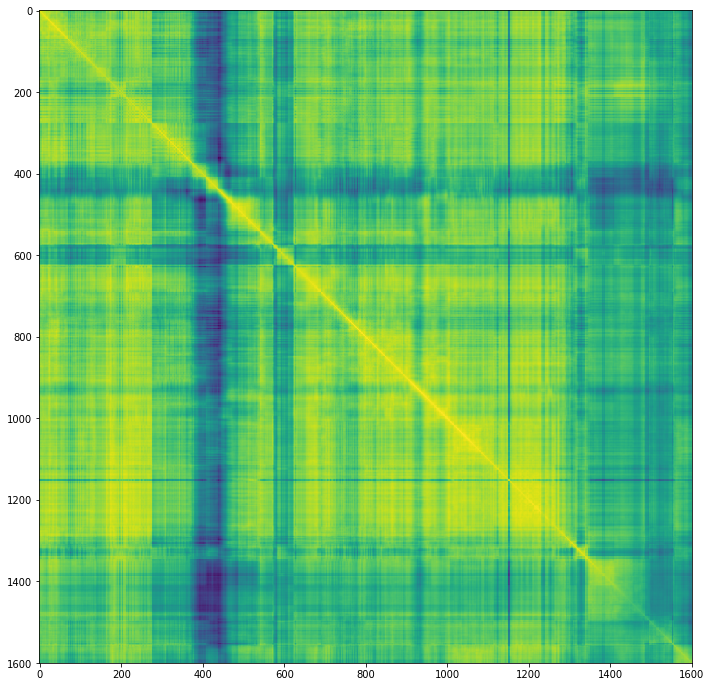

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.imshow(ccmat_300)

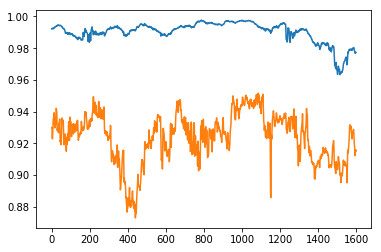

In [24]:
plt.plot(ccmat_300.max(0))
plt.plot(ccmat_300.min(0))

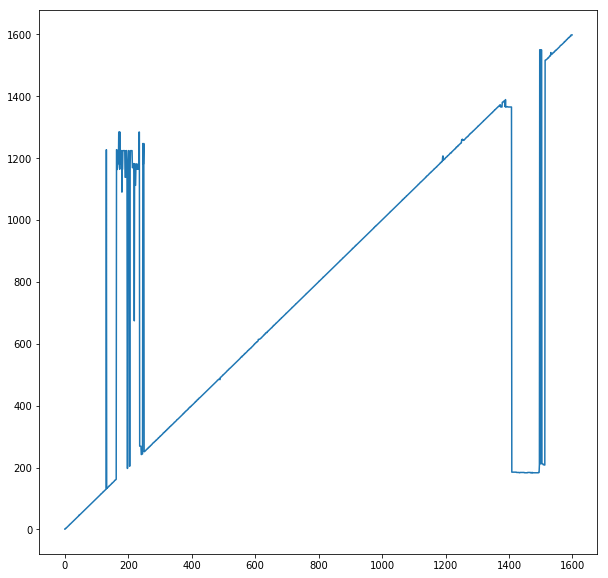

In [25]:
plt.figure(figsize=(10,10))
plt.plot(ccmat_300.argmax(0))

In [26]:
ind = np.arange(ccmat_300.shape[0])
ccmat_300_2 = ccmat_300.copy()
ccmat_300_2[ind, ind] = 0.0

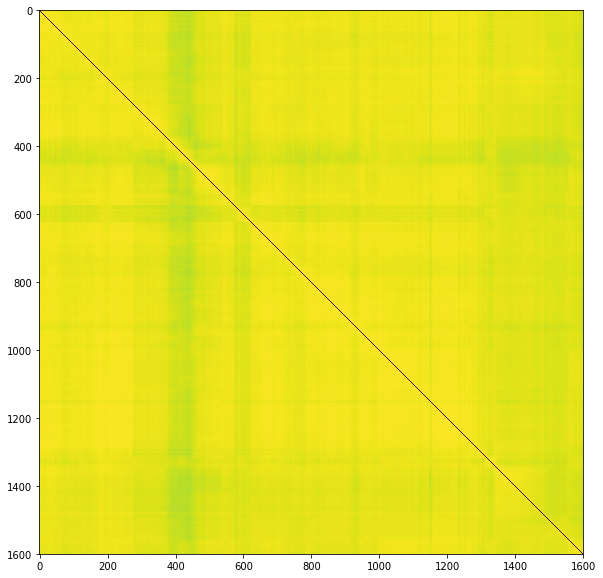

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(ccmat_300_2)

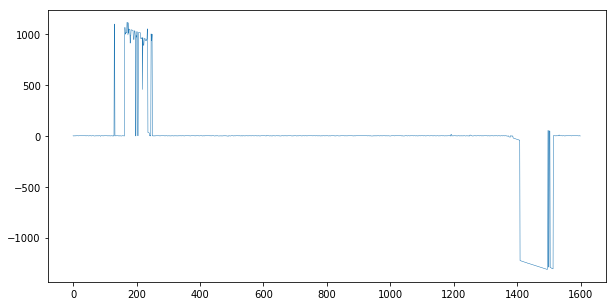

In [28]:
plt.figure(figsize=(10,5))
plt.plot(ccmat_300_2.argmax(0) - ind, lw=0.5)